In [21]:
import os
import pandas as pd
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

In [22]:
%%capture
%run credentials.ipynb

In [23]:
MY_SPOTIFY_ID = "11156353201"

In [24]:
def get_token(scope, user_id):
    return util.prompt_for_user_token(user_id, scope)

 <br>
 <h2>What have I been listening to recently</h2>
 <br>

In [ ]:
token = get_token('user-top-read', MY_SPOTIFY_ID)
    
if token:
    sp = spotipy.Spotify(auth=token)
    sp.trace = False
    
    artists = sp.current_user_top_artists(time_range='short_term', limit=30)
    tracks = sp.current_user_top_tracks(time_range='short_term', limit=30)
        
else:
    print("not found")

In [ ]:
df_artists = pd.DataFrame(artists['items'], columns=['name', 'genres', 'uri'])

In [ ]:
from collections import ChainMap

df_tracks = pd.DataFrame(tracks['items'], columns=['artists', 'name'])
concatenated_df_tracks_artists = list(map(lambda x: dict(ChainMap(*x)), df_tracks['artists']))
tracks_artists_names = [x['name'] for x in concatenated_df_tracks_artists]
df_tracks_artists_names = pd.DataFrame(tracks_artists_names, columns={'artist': tracks_artists_names})
df_tracks_names = pd.DataFrame(tracks['items'], columns=['name'])

In [ ]:
df_tracks = df_tracks.join(df_tracks_artists_names)
df_tracks.drop('artists', axis=1)

<br>
<br>
<h2>What features of songs I prefer comparing to other users<h2>
<h6> the global data comes from <a href="https://www.kaggle.com/geomack/spotifyclassification/version/1" target="blank">kaggle</a></h6>

In [ ]:
import itertools as it
import numpy as np
import seaborn as sb

import time
import operator as op

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [ ]:
token = get_token('user-library-read', MY_SPOTIFY_ID)

if token:
    sp = spotipy.Spotify(auth=token)
    results = sp.current_user_saved_albums(limit=50)
else:
    print("not found")
    
items = results['items']

while results['next']:
    results = sp.next(results)
    items.extend(results['items'])
    
albums_id = list(map(lambda x: x.get('album', {}).get('id'), items))

tracks = []

for album_id in albums_id:
    try: 
        tracks.append(sp.album_tracks(album_id)['items'])
    except:
        time.sleep(5)
        tracks.append(sp.album_tracks(album_id)['items'])
        
        
tracks = list(it.chain.from_iterable(tracks))
tracks_ids = [track['id'] for track in tracks]

track_grouper = it.groupby(enumerate(tracks_ids), key=lambda pair: pair[0]//50)
track_chunks = [list(map(op.itemgetter(1), group)) for _, group in track_grouper]

features = list(it.chain.from_iterable(sp.audio_features(chunk) for chunk in track_chunks))

In [ ]:
my_data = pd.read_csv('my_data.csv')
my_data = my_data.drop(['analysis_url', 'id', 'uri', 'type', 'track_href', 'time_signature', 'key', 'analysis_url', 'Unnamed: 0'], axis=1);

global_data = pd.read_csv('data.csv')
global_data = global_data.drop(columns=['time_signature', 'song_title', 'artist', 'target', 'key', 'Unnamed: 0'], axis=1);

In [ ]:
maxs = my_data.max()

for column in my_data.columns:
    my_data[column] = my_data[column].div(maxs[column])
    
for column in global_data.columns:
    global_data[column] = global_data[column].div(maxs[column])

In [ ]:
loudness_min = my_data['loudness'].min()
my_data['loudness'] = (my_data['loudness'] + abs(loudness_min)) * 0.1
global_data['loudness'] = (global_data['loudness'] + abs(loudness_min)) * 0.1

In [ ]:
my_data_means = pd.DataFrame(my_data.mean(axis=0)).T
global_data_means = pd.DataFrame(global_data.mean(axis=0)).T

my_data_means['owner'] = 'me'
global_data_means['owner'] = 'kaggle users'

means = my_data_means.append(global_data_means)

In [ ]:
melted = means.melt('owner', var_name='columns', value_name='values')
sb.catplot(x='columns', y='values', hue='owner', data=melted, kind='bar', height=8, legend_out=False, palette=['#9a5f53', '#4b655d'])
plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Music Features', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.legend(fontsize=12)
plt.show()

In [ ]:
sb.set(rc={'figure.figsize':(22,15)})

plt.subplot(331)
sb.distplot(my_data['danceability'], label='me')
sb.distplot(global_data['danceability'], color='r', label='kaggle users')
plt.xlabel('danceability', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(332)
sb.distplot(my_data['loudness'], label='me')
sb.distplot(global_data['loudness'], color='r', label='kaggle users')
plt.xlabel('loudness', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(333)
sb.distplot(my_data['instrumentalness'], label='me')
sb.distplot(global_data['instrumentalness'], color='r', label='kaggle users')
plt.xlabel('instrumentalness', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(334)
sb.distplot(my_data['liveness'], label='me')
sb.distplot(global_data['liveness'], color='r', label='kaggle users')
plt.xlabel('liveness', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(335)
sb.distplot(my_data['valence'], label='me')
sb.distplot(global_data['valence'], color='r', label='kaggle users')
plt.xlabel('valence', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(336)
sb.distplot(my_data['acousticness'], label='me')
sb.distplot(global_data['acousticness'], color='r', label='kaggle users')
plt.xlabel('acousticness', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(337)
sb.distplot(my_data['tempo'], label='me')
sb.distplot(global_data['tempo'], color='r', label='kaggle users')
plt.xlabel('tempo', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(338)
sb.distplot(my_data['speechiness'], label='me')
sb.distplot(global_data['speechiness'], color='r', label='kaggle users')
plt.xlabel('speechiness', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(339)
sb.distplot(my_data['energy'], label='me')
sb.distplot(global_data['energy'], color='r', label='kaggle users')
plt.xlabel('energy', fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

<br>

<h2>Predicting my new discover weekly playlist with decision tree classifier</h2>
<h6>the 'good' data comes from my own library and the 'bad' data is extracted from a new playlist I've made for purpose of this workbook (actually, I really hate those songs)</h6>

In [42]:
import io
import itertools as it
import operator as op

import pydotplus
from scipy import misc
import numpy as np
import seaborn as sb
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import imageio

my_data = pd.read_csv('my_data.csv')
my_data = my_data.drop(['analysis_url', 'id', 'uri', 'type', 'track_href', 'time_signature', 'key', 'analysis_url', 'Unnamed: 0'], axis=1)
my_data['target'] = 1

In [43]:
token = get_token('user-library-read playlist-read-private', MY_SPOTIFY_ID)

if token:
    sp = spotipy.Spotify(auth=token)
    results = sp.user_playlist(MY_SPOTIFY_ID, "7i6fdtv8eTSLziXGrxdPWs")
else:
    print("not found")

In [ ]:
bad_tracks = results['tracks']
bad_songs = bad_tracks['items']

while bad_tracks['next']:
    bad_tracks = sp.next(bad_tracks)
    for item in bad_tracks['items']:
        bad_songs.append(item)
        
bad_songs_id = [bad_song['track']['id'] for bad_song in bad_songs]
bad_songs_id = list(filter(lambda x: x is not None, bad_songs_id))

bad_songs_features = []

for i in range(0, len(bad_songs_id), 50):
    audio_features = sp.audio_features(bad_songs_id[i:i+50])
    for track in audio_features:
        bad_songs_features.append(track)
        bad_songs_features[-1]['target'] = 0

In [44]:
positive_features = pd.DataFrame(my_data)
negative_features = pd.read_csv('negative_features.csv')
positive_features = positive_features[:len(negative_features)]
negative_features = negative_features.drop(['analysis_url', 'id', 'time_signature', 'type', 'uri', 'key', 'track_href', 'Unnamed: 0'], axis=1)
negative_cols = negative_features.columns.tolist()
negative_cols.pop(9)
negative_cols.append('target')
negative_features = negative_features[negative_cols]

features = pd.concat([positive_features, negative_features])

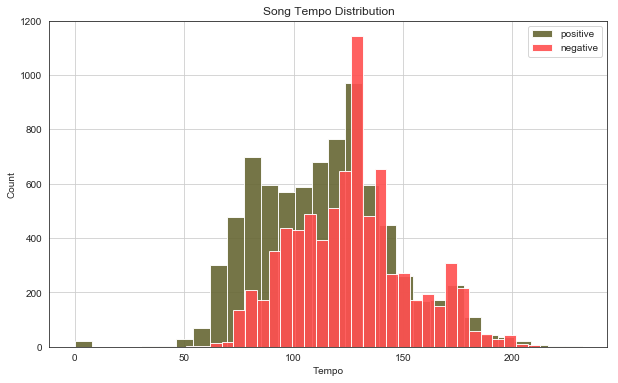

In [46]:
palette = sb.color_palette(['#666633', '#ff5050'])
sb.set_palette(palette)
sb.set_style('white')

positive_tempo = features[features['target'] == 1]['tempo']
negative_tempo = features[features['target'] == 0]['tempo']

fig = plt.figure(figsize=(10, 6))
positive_tempo.hist(bins=30, alpha=0.9, label="positive")
negative_tempo.hist(bins=30, alpha=0.9, label="negative")
plt.title("Song Tempo Distribution")
plt.xlabel('Tempo')
plt.ylabel('Count')
plt.legend(loc="upper right")

<br>

In [47]:
train, test = train_test_split(features, test_size = 0.15)
c = DecisionTreeClassifier(min_samples_split=900)

In [48]:
features = features.columns.tolist()
features.pop(-1);

In [49]:
x_train = train[features]
y_train = train['target']

x_test = train[features]
y_test = train['target']

In [50]:
dt = c.fit(x_train, y_train)

In [51]:
def show_tree(tree, features, path):
    f = io.StringIO()
    export_graphviz(tree, out_file=f, feature_names=features)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    img = imageio.imread(path)
    plt.rcParams['figure.figsize'] = (20, 20)
    plt.imshow(img)

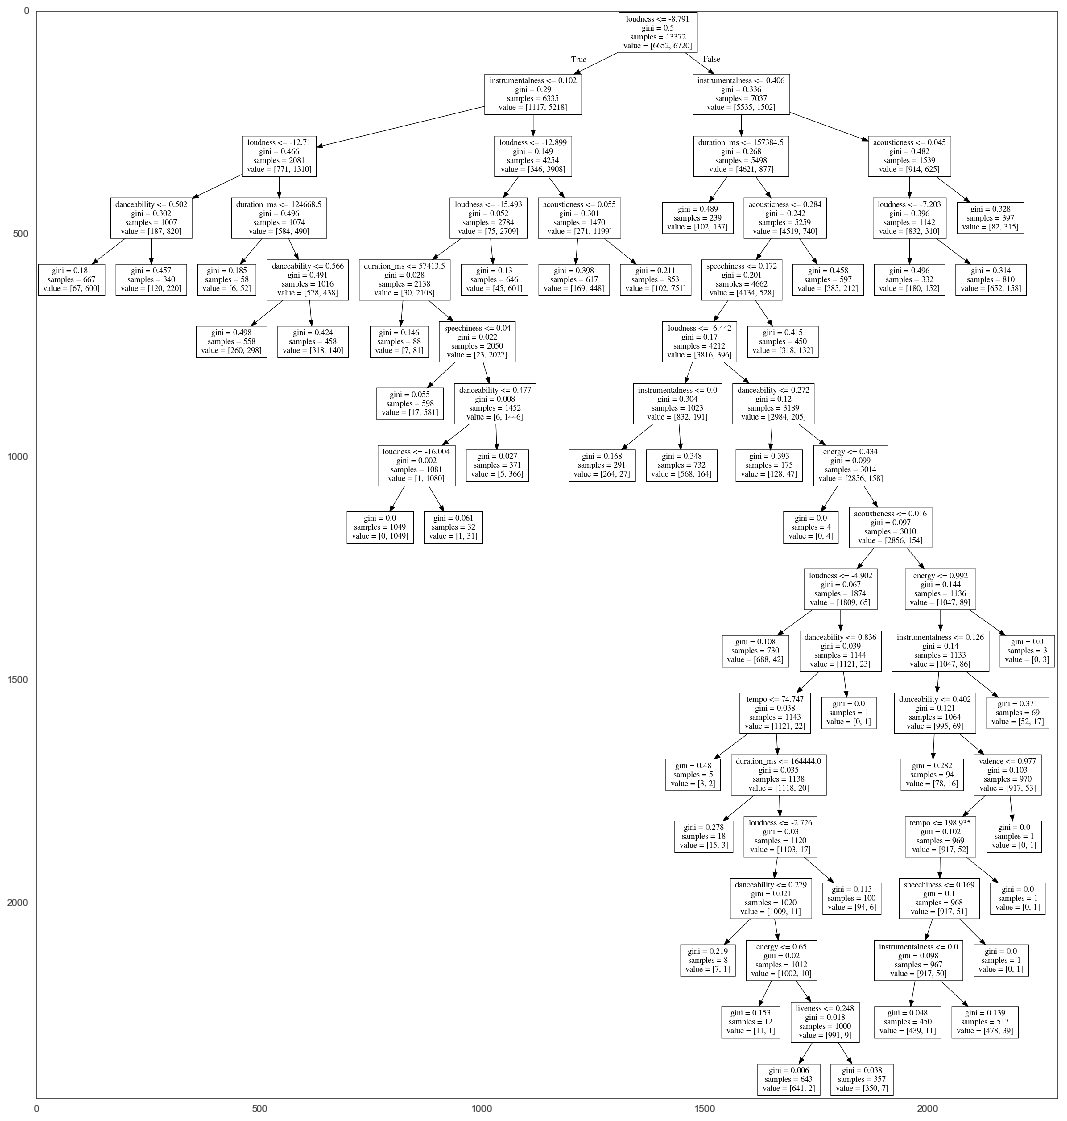

In [52]:
show_tree(dt, features, 'dec_tree_01.png')

In [53]:
y_pred = c.predict(x_test)
y_pred

array([1, 0, 1, ..., 0, 0, 1])

In [54]:
score = accuracy_score(y_test, y_pred) * 100
score

83.8318875261741

In [59]:
playlist = sp.user_playlist(MY_SPOTIFY_ID, '7fSPpaUsXvJFBB4Wk9SAHd')
playlist = playlist['tracks']['items']
playlist_songs_ids = [song['track']['id'] for song in playlist]
playlist_features = []

for i in range(0, len(playlist_songs_ids)):
    audio_features = sp.audio_features(playlist_songs_ids[i])
    for track in audio_features:
        playlist_features.append(track)

In [60]:
playlist_features = pd.DataFrame(playlist_features)

In [67]:
pred = c.predict(playlist_features[features])
i = 0
for prediction in pred:
    if(prediction == 1):
        print ( str(i) + " id: " + playlist_features["id"][i] )
        i = i +1

0 id: 5IGLjdAP8wCeaJhum4PJFA
1 id: 2u9HkCJUIfofPGMyiEBh7C
2 id: 6JJNzz6hXfM4WHju0QnRlf
3 id: 1BtGigq4NG0o9sF0u9cQNL
4 id: 3u2GOv0MDP9U2qkbtBr3IG
5 id: 75BtNxZn2nUCI0hsjbyYJn
6 id: 5s2MXJez7nCvO9avfgAVip
7 id: 4d3xyYaLW12Fl8auJAu5D9
8 id: 2EUMPAzWLdin92I071Yfxe
9 id: 3z7Q3ej2IKjVFvz9cGU6SM
10 id: 55BD1acjjT7DzvBexWT8zi
11 id: 6OpxLZaz09W43VEIwTwFVE
12 id: 0mUjCSRtXbLSpRw0Y7xgoT
13 id: 45rs03pyFwwXrwEkCJs6Ov
14 id: 68DBou7PMvbKZeukhojZau
15 id: 57ZkY3L2ySMSrogQVOXBV6
16 id: 3m2eOkUvXv7cgsBBZZCpU0
17 id: 43YfkX6qkKjAG8h4tIqFNf
18 id: 2fMTW4EpYmqg0Y8xocrfVp
19 id: 3rUuPn7iygVvDFNRqGIaX4
20 id: 7AJrPnFvJ51NzZbyFJZ3bH
21 id: 7cnx4UfJjrty2zz8x9xle6
22 id: 5GxMV63IqG3k5RY5CMzRIu
23 id: 4xunOkC5V68y9nrGaqSi7X
24 id: 1rWANPQpmmyDJxDdHozX0a
25 id: 5TSv7LTy9ZFQJvfHMOWSNN
26 id: 1a7fElZGsSJ8wb9xSVZUgN
27 id: 1PBLubGrz1UCN45UuRVj5I
28 id: 2Yj6TFILkSWxI01ulkfSH1
29 id: 6e8K1k8HLrp7jNFYdgYWeK
30 id: 0CM6MK4wPu9BVq3G1O9rok
31 id: 1Uj2QpjorXeZmPKf8kIQ82
32 id: 7F8HEUvit1sORhtePIm4N2
